In [2]:
import torch, os
torch.manual_seed(0) 
import warnings;warnings.filterwarnings("ignore")
from HINT.dataloader import csv_three_feature_2_dataloader, generate_admet_dataloader_lst
from HINT.molecule_encode import MPNN, ADMET
from HINT.icdcode_encode import GRAM, build_icdcode2ancestor_dict
from HINT.protocol_encode import Protocol_Embedding
from HINT.model import HINTModel 
device = torch.device("cpu")  ## cuda:0
if not os.path.exists("figure"):
    os.makedirs("figure")
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
base_name = 'phase_I' ### 'toy', 'phase_I', 'phase_II', 'phase_III', 'indication'
datafolder = "data"
train_file = os.path.join(datafolder, base_name + '_train.csv')
valid_file = os.path.join(datafolder, base_name + '_valid.csv')
test_file = os.path.join(datafolder, base_name + '_test.csv')

train_loader = csv_three_feature_2_dataloader(train_file, shuffle=True, batch_size=32) 
valid_loader = csv_three_feature_2_dataloader(valid_file, shuffle=False, batch_size=32) 
test_loader = csv_three_feature_2_dataloader(test_file, shuffle=False, batch_size=32) 

In [4]:
mpnn_model = MPNN(mpnn_hidden_size = 50, mpnn_depth=3, device = device)
icdcode2ancestor_dict = build_icdcode2ancestor_dict()
gram_model = GRAM(embedding_dim = 50, icdcode2ancestor = icdcode2ancestor_dict, device = device)
protocol_model = Protocol_Embedding(output_dim = 50, highway_num=3, device = device)

molecule_encoder = mpnn_model
disease_encoder = gram_model
protocol_encoder = protocol_model

In [5]:
def get_embed(dataloader):
    nctid_lst, label_lst, smiles_lst2, icdcode_lst3, criteria_lst = [], [], [], [], []
    for nctid, label, smiles, icdcode, criteria in dataloader:
        nctid_lst.extend(nctid)
        label_lst.extend([i.item() for i in label])
        smiles_lst2.extend(smiles)
        icdcode_lst3.extend(icdcode)
        criteria_lst.extend(criteria)
        
    molecule_embed = molecule_encoder.forward_smiles_lst_lst(smiles_lst2)
    icd_embed = disease_encoder.forward_code_lst3(icdcode_lst3)
    protocol_embed = protocol_encoder.forward(criteria_lst)
    print(molecule_embed.shape, icd_embed.shape, protocol_embed.shape)
    return molecule_embed, icd_embed, protocol_embed

In [6]:
def preprocess(file, loader):
    df = pd.read_csv(file)
    df.drop(['phase', 'why_stop'], axis=1, inplace=True)
    df.drop(['icdcodes', 'smiless', 'criteria'], axis=1, inplace=True)
    df.drop(['diseases', 'drugs'], axis=1, inplace=True) ## FE later
    
    molecule_embed, icd_embed, protocol_embed = get_embed(loader)

    molecule_df = pd.DataFrame(molecule_embed.detach().numpy(), columns=[f'molecule_feature_{i}' for i in range(len(molecule_embed[0]))])
    icd_df = pd.DataFrame(icd_embed.detach().numpy(), columns=[f'icd_feature_{i}' for i in range(len(icd_embed[0]))])
    protocol_df = pd.DataFrame(protocol_embed.detach().numpy(), columns=[f'protocol_feature_{i}' for i in range(len(protocol_embed[0]))])

    df = pd.concat([df, molecule_df, icd_df, protocol_df], axis=1)
    return df

In [7]:
train_df = preprocess(train_file, train_loader)
valid_df = preprocess(valid_file, valid_loader)
test_df = preprocess(test_file, test_loader)
print(train_df.shape, valid_df.shape, test_df.shape)

torch.Size([1044, 50]) torch.Size([1044, 50]) torch.Size([1044, 50])
torch.Size([117, 50]) torch.Size([117, 50]) torch.Size([117, 50])
torch.Size([627, 50]) torch.Size([627, 50]) torch.Size([627, 50])
(1044, 153) (117, 153) (627, 153)


In [8]:
train_idx = range(len(train_df))
valid_idx = range(len(train_df), len(train_df) + len(valid_df))
test_idx = range(len(train_df) + len(valid_df), len(train_df) + len(valid_df) + len(test_df))

combined_df = pd.DataFrame()
combined_df = pd.concat([train_df, valid_df, test_df], axis=0)
combined_df.reset_index(drop=True, inplace=True)
combined_df = pd.get_dummies(combined_df, columns=['status'], drop_first=True)

train_clean = combined_df.loc[train_idx]
valid_clean = combined_df.loc[valid_idx]
test_clean = combined_df.loc[test_idx]

In [9]:
X_train, y_train = train_clean.drop(['nctid','label'], axis=1), train_clean['label']  
X_valid, y_valid = valid_clean.drop(['nctid','label'], axis=1), valid_clean['label']  
X_test, y_test = test_clean.drop(['nctid','label'], axis=1), test_clean['label']  
print(X_train.shape, X_valid.shape, X_test.shape)

(1044, 156) (117, 156) (627, 156)


In [10]:
X_test.isnull().sum().sort_values(ascending=False)  # no missing data

molecule_feature_0    0
protocol_feature_7    0
protocol_feature_0    0
protocol_feature_1    0
protocol_feature_2    0
                     ..
icd_feature_2         0
icd_feature_3         0
icd_feature_4         0
icd_feature_5         0
status_withdrawn      0
Length: 156, dtype: int64

In [11]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_recall_curve, precision_score, recall_score, auc

model = xgb.XGBClassifier(n_estimators=200)
# hyperparameters = {
#     'learning_rate': [0.05, 0.1, 0.15, 0.2],
#     'max_depth': [3, 4, 5],
#     'alpha': [5, 10, 15],
#     'n_estimators': [100, 200]
# }
# grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='accuracy', verbose=1)
# grid_search.fit(X_train, y_train)

# print(grid_search.best_params_)
# print(grid_search.best_score_)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [12]:
from sklearn.metrics import accuracy_score
# model = grid_search.best_estimator_
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)
y_pred_test = model.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score(y_pred_valid, y_valid))
print(accuracy_score(y_pred_test, y_test))

0.9894636015325671
0.7863247863247863
0.8500797448165869


In [13]:
def print_metrics(y_true, y_pred, label):
    print(f"{label} ROC AUC: {roc_auc_score(y_true, y_pred)}")
    print(f"{label} F1: {f1_score(y_true, y_pred)}")
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    print(f"{label} PR-AUC: {auc(recall, precision)}")
    print(f"{label} Precision: {precision_score(y_true, y_pred)}")
    print(f"{label} Recall: {recall_score(y_true, y_pred)}")
    print(f"{label} Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"{label} Predict 1 ratio: {sum(y_pred) / len(y_pred)}")
    print(f"{label} Label 1 ratio: {sum(y_true) / len(y_true)}")

# print_metrics(y_train, y_pred_train, 'Train')
# print_metrics(y_valid, y_pred_valid, 'Valid')
print_metrics(y_test, y_pred_test, 'Test')

Test ROC AUC: 0.8452449567723342
Test F1: 0.8679775280898876
Test PR-AUC: 0.8988356583082412
Test Precision: 0.8465753424657534
Test Recall: 0.8904899135446686
Test Accuracy: 0.8500797448165869
Test Predict 1 ratio: 0.5821371610845295
Test Label 1 ratio: 0.5534290271132376


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


ValueError: ⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory scaling of TabPFN). Please confirm you want to run by passing overwrite_warning=True to the fit function.

In [20]:
X_train.iloc[:, :30]

,molecule_feature_0,molecule_feature_1,molecule_feature_2,molecule_feature_3,molecule_feature_4,molecule_feature_5,molecule_feature_6,molecule_feature_7,molecule_feature_8,molecule_feature_9,...,molecule_feature_20,molecule_feature_21,molecule_feature_22,molecule_feature_23,molecule_feature_24,molecule_feature_25,molecule_feature_26,molecule_feature_27,molecule_feature_28,molecule_feature_29
0,0.033171,0.429924,0.000000,0.225531,0.286493,0.045113,0.002732,0.015200,0.133832,0.067503,...,0.000000,0.0,0.230643,0.066331,0.001391,0.001860,0.000000,0.125376,0.187237,0.0
1,0.057181,0.421897,0.000000,0.149416,0.242703,0.054480,0.001318,0.013474,0.158116,0.027636,...,0.000000,0.0,0.195008,0.094277,0.000000,0.000000,0.000000,0.086766,0.191362,0.0
2,0.021085,0.343111,0.002222,0.157809,0.110490,0.035163,0.047431,0.044525,0.152534,0.000000,...,0.012223,0.0,0.214767,0.094898,0.016626,0.000000,0.007256,0.003441,0.086140,0.0
3,0.027299,0.445390,0.000000,0.214666,0.259395,0.065382,0.008721,0.013319,0.181528,0.042554,...,0.000000,0.0,0.233863,0.099653,0.000000,0.000018,0.000000,0.087681,0.140342,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4000,0.046537,0.447805,0.000000,0.168461,0.291089,0.078345,0.000659,0.010672,0.160778,0.057348,...,0.000000,0.0,0.189778,0.073527,0.000000,0.006248,0.000000,0.114376,0.189200,0.0
4001,0.032167,0.216792,0.000000,0.088911,0.110187,0.030899,0.006014,0.005263,0.078193,0.020408,...,0.000000,0.0,0.114866,0.054350,0.000000,0.000235,0.000000,0.043452,0.081098,0.0
4002,0.057181,0.421897,0.000000,0.149416,0.242703,0.054480,0.001318,0.013474,0.158116,0.027636,...,0.000000,0.0,0.195008,0.094277,0.000000,0.000000,0.000000,0.086766,0.191362,0.0
4003,0.068256,0.407701,0.000000,0.153785,0.218780,0.047733,0.002585,0.015602,0.137692,0.028981,...,0.000000,0.0,0.200846,0.092658,0.000000,0.000000,0.000000,0.092175,0.195576,0.0


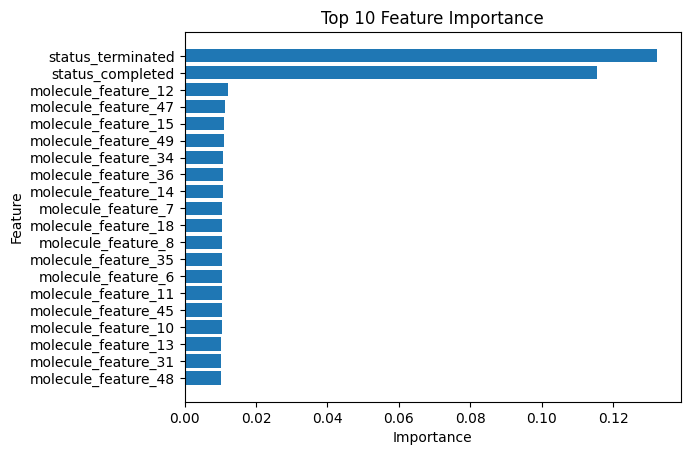

In [28]:
feature_model = RandomForestClassifier(n_estimators=100, random_state=42)
feature_model.fit(X_train, y_train)
feature_importance = feature_model.feature_importances_

features = X_train.columns
importance_df = pd.DataFrame({'feature': features, 'importance': feature_importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.barh(importance_df['feature'][:20], importance_df['importance'][:20])  # Top 10 important features
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()